In [0]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt

import scipy
from statsmodels.stats.weightstats import *

In [0]:
#a_web = a_web.drop(columns=['Unnamed: 0','uid','kk_id_x','ref','bizmod_x','cdt','kk_id_y','bizmod_y','view','response'])

In [0]:
#a_web.to_excel(r'C:/Users/Profi/Downloads/example.xlsx')

In [0]:
a_web = pd.read_excel('C:/Users/Profi/Downloads/example.xlsx')

In [0]:
a_web.dtypes

case_id             object
spec_id             object
order_id           float64
first_dt    datetime64[ns]
e_dt        datetime64[ns]
d_view      datetime64[ns]
dtype: object

,case_id,spec_id,order_id,first_dt,e_dt,d_view
0,B,ffa2dd59dc131d92994c2f267c19251dbb836ecbb11eec...,NaN,NaT,NaT,NaT
1,B,e800fca7e8c2e643c56572d66933bfeaf2cc66a914328d...,NaN,NaT,NaT,NaT
2,B,c28ed784882c00fff28a0b0fdd434127bb5de905ca2318...,NaN,NaT,NaT,NaT
3,B,f651bd1ee3f165513b5096aa0e858529da005ae656563e...,NaN,NaT,NaT,NaT
4,B,002fa07fb4f6c54fcc8934855e7bd5fe2167f8526c23f6...,NaN,NaT,NaT,NaT
...,...,...,...,...,...,...
302359,A,b6255234f9ac0a8c610b2c332e34c6a9f9ae4d6e0d109d...,18252119.0,2019-04-01 16:18:43,2019-04-01 16:26:39,2019-04-01
302360,A,b6255234f9ac0a8c610b2c332e34c6a9f9ae4d6e0d109d...,18353035.0,2019-04-08 14:53:00,NaT,2019-04-08
302361,A,d90a88dc6b6428d9c13d12666d6955703a1e0a77947053...,NaN,NaT,NaT,NaT
302362,A,131eaa2b170fb675b5b37bc464aaa9fed5147b8e6dd333...,NaN,NaT,NaT,NaT


In [0]:
a_web ['e_dt'] = pd.to_datetime(a_web ['e_dt']).dt.day

# Конверсия и p-value

In [0]:
# для удобства подсчетов
a_web['view'] = a_web.apply(lambda x: str(x.spec_id) + str(x.order_id)  if ~np.isnan(x.order_id) else np.nan, axis=1)
a_web['response'] = a_web.apply(lambda x: str(x.spec_id) + str(x.order_id)  if ~np.isnan(x.e_dt) else np.nan, axis=1)

In [0]:
a_views = a_web.groupby(['case_id','d_view']).agg({'view':'nunique','response':'nunique'})
c = a_views.groupby('case_id').cumsum()
c['conversion']=c.response/c.view

In [0]:
c.query("d_view=='2019-04-19'")

,,view,response,conversion
case_id,d_view,,,
A,2019-04-19,90488,18390,0.203231
B,2019-04-19,101343,17884,0.176470


In [0]:
import pylab
import matplotlib.dates as mdates

C:\Users\Profi\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


Text(0, 0.5, 'Разница В-А, процентные пункты')

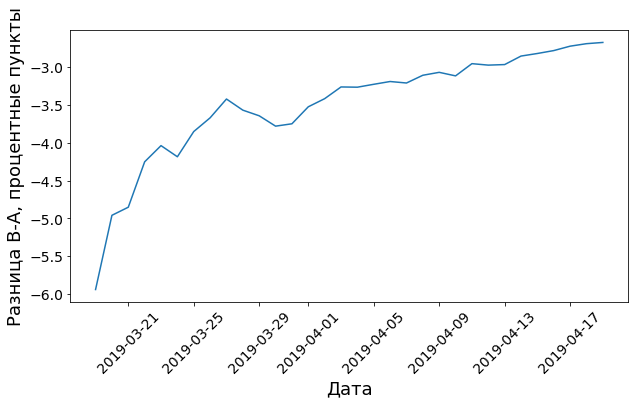

In [0]:
diff = pd.DataFrame(c.conversion.loc['B'] - c.conversion.loc['A'])

fig, ax = plt.subplots(1,1,figsize = (10,5))
ax.plot(diff*100)
myFmt = mdates.DateFormatter('%Y-%m-%d')
ax.xaxis.set_major_formatter(myFmt)
plt.xticks(fontsize=14)
plt.xticks(rotation=45)
plt.yticks(fontsize=14)
plt.xlabel("Дата",fontsize=18)
plt.ylabel("Разница В-А, процентные пункты",fontsize=18)

# diff.plot(kind='line',alpha=0.75, rot=0)
# plt.xlabel("")
# plt.show()

Text(0, 0.5, 'p-value, логарифм. шкала')

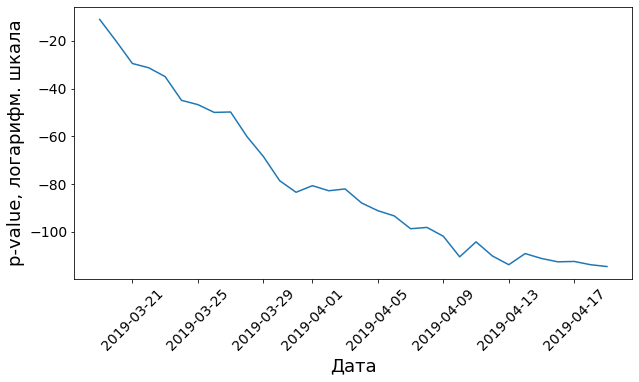

In [0]:
from statsmodels.stats.proportion import proportions_ztest
new_ar=[]
for i in range(len(c.loc['A'])):
    count = np.array([c.response.loc['A'][i], c.response.loc['B'][i]])
    nobs = np.array([c.view.loc['A'][i], c.view.loc['B'][i]])
    stat, pval = proportions_ztest(count, nobs)
    new_ar.append(pval)
    
p_value = pd.DataFrame(new_ar)
p_value = p_value.rename(columns={0: "p_val"})
p_value['date'] =  c.loc['A'].reset_index().d_view

p_value = p_value.set_index('date')

# p_value.plot(kind='line',alpha=10, rot=0,logy=True,figsize=(15,10),fontsize = 18)
# ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y'))
# ax.set_yscale('log')

fig, ax = plt.subplots(1,1,figsize = (10,5))
ax.plot(np.log(p_value.p_val))
myFmt = mdates.DateFormatter('%Y-%m-%d')
ax.xaxis.set_major_formatter(myFmt)
plt.xticks(fontsize=14)
plt.xticks(rotation=45)
plt.yticks(fontsize=14)
plt.xlabel("Дата",fontsize=18)
plt.ylabel("p-value, логарифм. шкала",fontsize=18)

# Метрики по спецам

In [0]:
a_views_by_spec = a_web.groupby(['case_id','spec_id']).agg({'view':'nunique','response':'nunique'})

In [0]:
a_views_by_spec

view  response
case_id spec_id                                                           
A       00005e804540ae2671aa53998ed7497983f89449746babe...     0         0
        00016f5b07b639fc203809bd914a2e307881c3eb8b69c62...     0         0
        00017abfb978e4c3f8d870b56f418d8dda19a9b3357b10f...     6         1
        0001d918d29aa0384ea723ae2514e60a44d6e2df71619d0...     0         0
        00021f0647e6380456ed7c76378ae06ba2f4a2a688a261e...     0         0
...                                                          ...       ...
B       fffb99c4e5f24d78ba4b2272fb2cd19aac1727002342cf4...     2         1
        fffc06887246af2d4d2684761b052fec0397fff643d2fe3...     3         1
        fffc0eb4c4efcbf4cb789d7da2ce7d01da36b79965e8344...     0         0
        ffff325cf26453d6a8565f892c80910b6e4c2253e4fd849...     0         0
        ffff80f4d8a4f9c81e91aeade906ea9bf4efe7c69b0b4c7...     0         0

[114330 rows x 2 columns]

In [0]:
a_views_by_spec.groupby('case_id').view.describe()

,count,mean,std,min,25%,50%,75%,max
case_id,,,,,,,,
A,56818.0,1.592594,7.271583,0.0,0.0,0.0,1.0,764.0
B,57512.0,1.762119,7.458915,0.0,0.0,0.0,1.0,363.0


In [0]:
a_views_by_spec.groupby('case_id').response.describe()

,count,mean,std,min,25%,50%,75%,max
case_id,,,,,,,,
A,56818.0,0.323665,3.16577,0.0,0.0,0.0,0.0,563.0
B,57512.0,0.310961,2.06235,0.0,0.0,0.0,0.0,209.0


Кто в  хвосте?

In [0]:
a_views_by_spec[a_views_by_spec.view>500]

,,view,response
case_id,spec_id,,
A,e33a77a7a3af3609b838d77341c00856c76bf761ecea5b477e0cddfc,764,563


# Метрики конверсии без бота

In [0]:
a_views_by_spec_clean = a_views_by_spec.query("spec_id!='e33a77a7a3af3609b838d77341c00856c76bf761ecea5b477e0cddfc'")

In [0]:
a_web_clean = a_web.query("spec_id!='e33a77a7a3af3609b838d77341c00856c76bf761ecea5b477e0cddfc'")

In [0]:
a_views_clean = a_web_clean.groupby(['case_id','d_view']).agg({'view':'nunique','response':'nunique'})
c_clean = a_views_clean.groupby('case_id').cumsum()
c_clean['conversion']=c_clean.response/c_clean.view

In [0]:
c_clean.query("d_view=='2019-04-19'") 

,,view,response,conversion
case_id,d_view,,,
A,2019-04-19,89724,17827,0.198687
B,2019-04-19,101343,17884,0.176470


Text(0, 0.5, 'Разница В-А, процентные пункты')

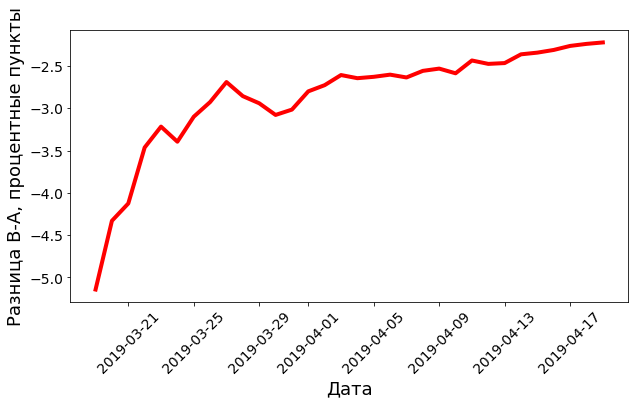

In [0]:
diff = pd.DataFrame(c_clean.conversion.loc['B'] - c_clean.conversion.loc['A'])
# diff.plot(kind='line',alpha=0.75, rot=0)
# plt.xlabel("")
# plt.show()
fig, ax = plt.subplots(1,1,figsize = (10,5))
ax.plot(diff*100,color='red',linewidth=4)
myFmt = mdates.DateFormatter('%Y-%m-%d')
ax.xaxis.set_major_formatter(myFmt)
plt.xticks(fontsize=14)
plt.xticks(rotation=45)
plt.yticks(fontsize=14)
plt.xlabel("Дата",fontsize=18)
plt.ylabel("Разница В-А, процентные пункты",fontsize=18)

Text(0, 0.5, 'p-value, логарифм. шкала')

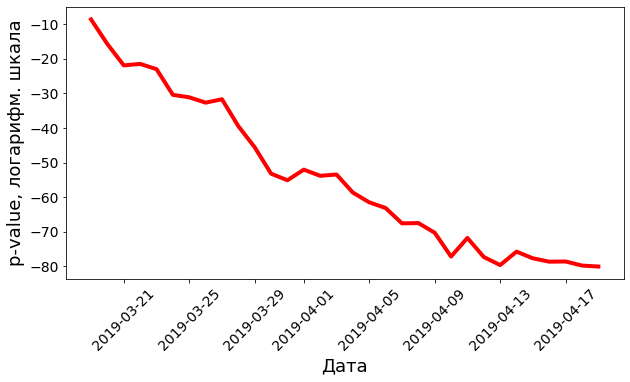

In [0]:
from statsmodels.stats.proportion import proportions_ztest
new_ar=[]
for i in range(len(c_clean.loc['A'])):
    count = np.array([c_clean.response.loc['A'][i], c_clean.response.loc['B'][i]])
    nobs = np.array([c_clean.view.loc['A'][i], c_clean.view.loc["B"][i]])
    stat, pval = proportions_ztest(count, nobs)
    new_ar.append(pval)
    
p_value = pd.DataFrame(new_ar)
p_value = p_value.rename(columns={0: "p_val"})
p_value['date'] = c_clean.loc['B'].reset_index().d_view
p_value = p_value.set_index('date')


fig, ax = plt.subplots(1,1,figsize = (10,5))
ax.plot(np.log(p_value.p_val),color='red',linewidth=4)
myFmt = mdates.DateFormatter('%Y-%m-%d')
ax.xaxis.set_major_formatter(myFmt)
plt.xticks(fontsize=14)
plt.xticks(rotation=45)
plt.yticks(fontsize=14)
plt.xlabel("Дата",fontsize=18)
plt.ylabel("p-value, логарифм. шкала",fontsize=18)

# p_value.plot(kind='line',alpha=10, rot=0,logy=True,figsize=(15,10),fontsize = 18)
# plt.xlabel("")
# plt.show()

# Метрики в разрезе по спецам, без бота

In [0]:
a_views_by_spec_clean.groupby('case_id').view.describe()

,count,mean,std,min,25%,50%,75%,max
case_id,,,,,,,,
A,56817.0,1.579175,6.530392,0.0,0.0,0.0,1.0,346.0
B,57512.0,1.762119,7.458915,0.0,0.0,0.0,1.0,363.0


In [0]:
a_views_by_spec_clean.groupby('case_id').response.describe()

,count,mean,std,min,25%,50%,75%,max
case_id,,,,,,,,
A,56817.0,0.313762,2.109437,0.0,0.0,0.0,0.0,313.0
B,57512.0,0.310961,2.062350,0.0,0.0,0.0,0.0,209.0


## Как выглядит распределение метрик 
- "среднее число просмотров на спеца"  
- "среднее число откликов на спеца"

Text(0, 0.5, 'Число специалистов')

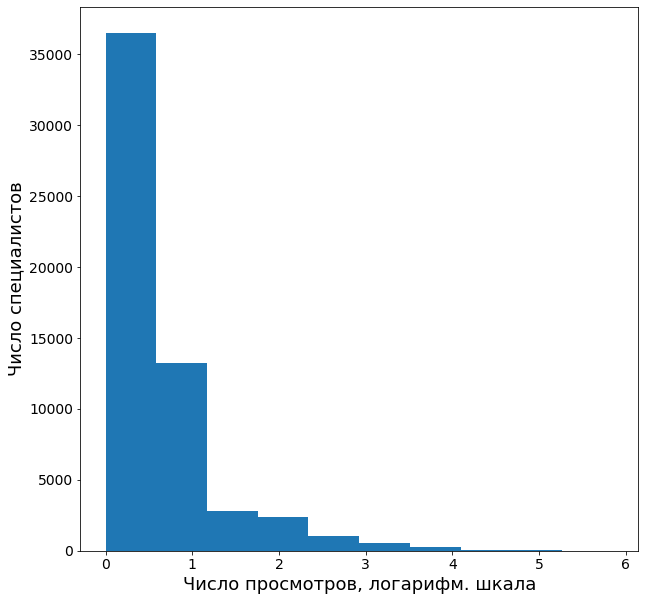

In [0]:
fig, ax = plt.subplots(1,1,figsize = (10,10))
ax.hist(np.log(a_views_by_spec_clean.loc['A'].view+1))
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Число просмотров, логарифм. шкала",fontsize=18)
plt.ylabel("Число специалистов",fontsize=18)

Text(0, 0.5, 'Число специалистов')

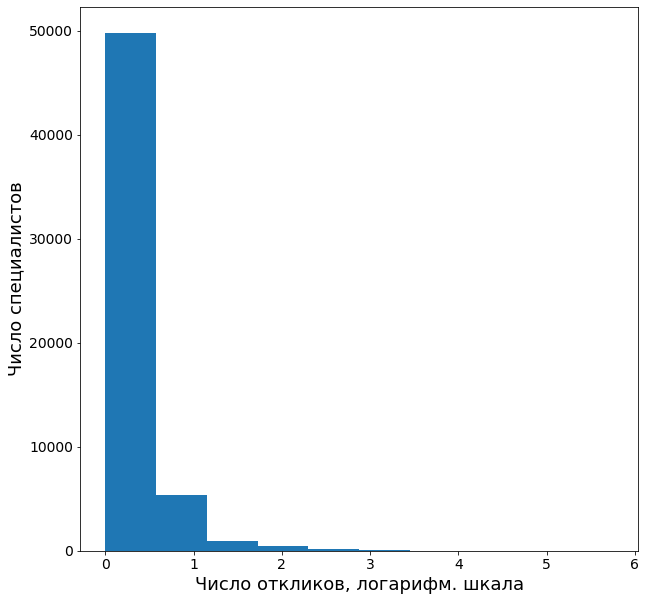

In [0]:
fig, ax = plt.subplots(1,1,figsize = (10,10))
ax.hist(np.log(a_views_by_spec_clean.loc['A'].response+1))
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Число откликов, логарифм. шкала",fontsize=18)
plt.ylabel("Число специалистов",fontsize=18)

In [0]:
def bootstrap(arr,n=100,N_TRIAL = 1000,func = np.mean):
    res = []
    n = min(len(arr),n)
    # Инициализируем цикл попыток
    for _ in range(N_TRIAL):
        # Делаем подвыборку размера n
        if len(arr.shape)>1:
            ind = np.random.choice(np.arange(arr.shape[0]), size = (n,))
            subsample = arr.iloc[ind]
        else:
            subsample = np.random.choice(arr, size = (n,))
        # рассчитываем статистику
        stat = func(subsample)
        res.append(stat)
    return res # shape (N_TRIAL,)

## Просмотры, значимость

In [0]:
samples_a = bootstrap(a_views_by_spec_clean.query("case_id=='A'")['view'],N_TRIAL = 3000)
samples_b = bootstrap(a_views_by_spec_clean.query("case_id=='B'")['view'],N_TRIAL = 3000)

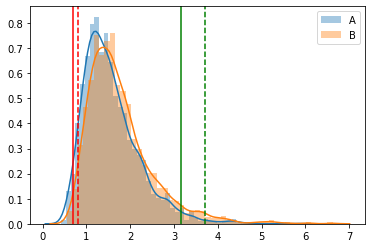

In [0]:
import seaborn as sns
ax = sns.distplot(samples_a,label = 'A')
sns.distplot(samples_b,ax = ax,label = 'B')
ax.legend(['A','B'])
ax.axvline(np.percentile(samples_a,2.5),linestyle = '-',color='r')
ax.axvline(np.percentile(samples_a,97.5),linestyle = '-',color='g')

ax.axvline(np.percentile(samples_b,2.5),linestyle = '--',color='r')
ax.axvline(np.percentile(samples_b,97.5),linestyle = '--',color='g')

In [0]:
buf = []
for i in range(1000):
    a_sample =  a_views_by_spec_clean.query("case_id=='A'")['view'].sample(100)
    b_sample =  a_views_by_spec_clean.query("case_id=='B'")['view'].sample(100)
    buf.append(np.mean(b_sample)-np.mean(a_sample))

min = -1.7102499999999996 max = 2.430999999999999


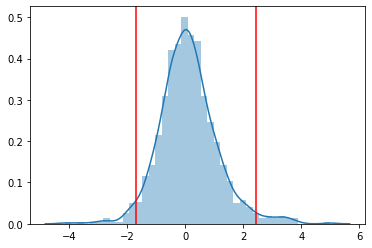

In [0]:
ax_buf = sns.distplot(buf)
ax_buf.axvline(np.percentile(buf,2.5),linestyle = '-',color='r')
ax_buf.axvline(np.percentile(buf,97.5),linestyle = '-',color='r')
print('min =',np.percentile(buf,2.5),'max =',np.percentile(buf,97.5))

## Отклики, значимость

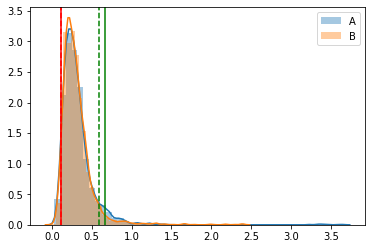

In [0]:
samples_a_resp = bootstrap(a_views_by_spec_clean.query("case_id=='A'")['response'],N_TRIAL = 3000)
samples_b_resp = bootstrap(a_views_by_spec_clean.query("case_id=='B'")['response'],N_TRIAL = 3000)
ax = sns.distplot(samples_a_resp,label = 'B')
sns.distplot(samples_b_resp,ax = ax,label = 'A')
ax.legend(['A','B'])
ax.axvline(np.percentile(samples_a_resp,5),linestyle = '-',color='r')
ax.axvline(np.percentile(samples_a_resp,95),linestyle = '-',color='g')

ax.axvline(np.percentile(samples_b_resp,5),linestyle = '--',color='r')
ax.axvline(np.percentile(samples_b_resp,95),linestyle = '--',color='g')

In [0]:
buf_1=[]
for i in range(1000):
    a_sample =  a_views_by_spec_clean.query("case_id=='A'")['response'].sample(100)
    b_sample =  a_views_by_spec_clean.query("case_id=='B'")['response'].sample(100)
    buf_1.append(np.mean(b_sample)-np.mean(a_sample))

min = -0.49049999999999994 max = 0.6507499999999994


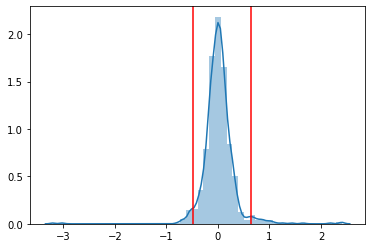

In [0]:
ax_buf = sns.distplot(buf_1)
ax_buf.axvline(np.percentile(buf_1,2.5),linestyle = '-',color='r')
ax_buf.axvline(np.percentile(buf_1,97.5),linestyle = '-',color='r')
print('min =',np.percentile(buf_1,2.5),'max =',np.percentile(buf_1,97.5))